# **Air quality - GIOS data analysis**
### Advanced Databases
### Automatic Control and Robotic, Cyber-physical Systems
#### **Daniel Jurkowski (407200) & Adam Pękala (405380) & Rafał Maciasz (405560) & Jakub Sacha (405521)**

## **1. Import required packages** 

In [50]:
import psycopg2
import requests
import pandas as pd
import matplotlib.pyplot as plt
import schedule
import time
import folium
from folium.plugins import MarkerCluster
import plotly.express as px
import datetime
import warnings

## **2. Connect to database**

In [63]:
db_name = 'gios_data'
db_user = 'postgres'
db_password = 'kochamadb'
db_host = 'localhost'
db_port = '5000'

conn = psycopg2.connect(
    dbname=db_name,
    user=db_user,
    password=db_password,
    host=db_host,
    port='5000'
)

## **3. Scrap and prepare data from chosen API.**

### **3.1. GET /pjp-api/rest/station/findAll** - List of all stations with cities details

In [64]:
stations_data = pd.DataFrame.from_dict(requests.get("https://api.gios.gov.pl/pjp-api/rest/station/findAll").json())
stations_data.rename(columns={"id": "stationId"}, inplace=True)

cities_data = pd.DataFrame.from_dict(list(stations_data["city"]))
cities_data.rename(columns={"id": "cityId"}, inplace=True)
cities_data = pd.concat([cities_data, pd.DataFrame.from_dict(list(cities_data["commune"]))], axis=1)
cities_data.drop(columns=["commune"], inplace=True)

stations_data = pd.concat([stations_data, cities_data], axis=1)
stations_data.drop(columns=["city"], inplace=True)

cities_data = cities_data.drop_duplicates(subset=["cityId"], keep="last").reset_index(drop=True)

In [60]:
stations_data.head()

,stationId,stationName,gegrLat,gegrLon,addressStreet,cityId,name,communeName,districtName,provinceName
0,114,"Wrocław, ul. Bartnicza",51.115933,17.141125,ul. Bartnicza,1064,Wrocław,Wrocław,Wrocław,DOLNOŚLĄSKIE
1,117,"Wrocław, wyb. Conrada-Korzeniowskiego",51.129378,17.029250,ul. Wyb. J.Conrada-Korzeniowskiego 18,1064,Wrocław,Wrocław,Wrocław,DOLNOŚLĄSKIE
2,129,"Wrocław, al. Wiśniowa",51.086225,17.012689,al. Wiśniowa/ul. Powst. Śląskich,1064,Wrocław,Wrocław,Wrocław,DOLNOŚLĄSKIE
3,52,"Legnica, al. Rzeczypospolitej",51.204503,16.180513,al. Rzeczypospolitej 10/12,453,Legnica,Legnica,Legnica,DOLNOŚLĄSKIE
4,109,"Wałbrzych, ul. Wysockiego",50.768729,16.269677,ul. Wysockiego 11,998,Wałbrzych,Wałbrzych,Wałbrzych,DOLNOŚLĄSKIE


In [55]:
cities_data.head()

,cityId,name,communeName,districtName,provinceName
0,1064,Wrocław,Wrocław,Wrocław,DOLNOŚLĄSKIE
1,453,Legnica,Legnica,Legnica,DOLNOŚLĄSKIE
2,998,Wałbrzych,Wałbrzych,Wałbrzych,DOLNOŚLĄSKIE
3,142,Czerniawa,Świeradów-Zdrój,lubański,DOLNOŚLĄSKIE
4,198,Dzierżoniów,Dzierżoniów,dzierżoniowski,DOLNOŚLĄSKIE


### **Create required tables**

In [65]:
cur = conn.cursor()

cur.execute('''
CREATE TABLE IF NOT EXISTS cities (
    city_id INTEGER PRIMARY KEY,
    name VARCHAR(255),
    province VARCHAR(255)
);
''')
conn.commit()


cur.execute('''
CREATE TABLE IF NOT EXISTS stations (
    station_id INTEGER PRIMARY KEY,
    city_id INTEGER,
    name VARCHAR(255),
    address_street VARCHAR(255),
    latitude FLOAT,
    longitude FLOAT,
    FOREIGN KEY (city_id)
        REFERENCES cities (city_id)
        ON UPDATE CASCADE ON DELETE CASCADE
);
''')
conn.commit()

### **Fill tables with scrapped data**

In [7]:
cur = conn.cursor()

for _, record in cities_data.iterrows():
    cur.execute(f'''
        INSERT INTO cities (city_id, name, province)
        VALUES ({record["cityId"]}, '{record["name"]}', '{record["provinceName"]}');
    ''')
conn.commit()

for _, record in stations_data.iterrows():
    cur.execute(f'''
        INSERT INTO stations (station_id, city_id, name, address_street, latitude, longitude)
        VALUES ({record["stationId"]}, {record["cityId"]}, '{record["stationName"]}', '{record["addressStreet"]}', '{record["gegrLat"]}', '{record["gegrLon"]}');
    ''')
conn.commit()

### **3.2. GET /pjp-api/rest/station/sensors/{station_id}** - List of all sensors available in each station 

In [8]:
sensors_data = pd.DataFrame.from_dict(sum([requests.get(f"https://api.gios.gov.pl/pjp-api/rest/station/sensors/{station_id}").json() for station_id in stations_data["stationId"]], []))  # Use sum to flatten 2d array
sensors_data.rename(columns={"id": "sensorId"}, inplace=True)

params_data = pd.DataFrame.from_dict(list(sensors_data["param"]))
params_data.rename(columns={"idParam": "paramId"}, inplace=True)

sensors_data = pd.concat([sensors_data, params_data], axis=1)
sensors_data.drop(columns=["param"], inplace=True)

params_data = params_data.drop_duplicates(subset=["paramId"], keep="last").reset_index(drop=True)

In [9]:
sensors_data.head()

,sensorId,stationId,paramName,paramFormula,paramCode,paramId
0,642,114,dwutlenek azotu,NO2,NO2,6
1,644,114,ozon,O3,O3,5
2,672,117,dwutlenek siarki,SO2,SO2,1
3,658,117,benzen,C6H6,C6H6,10
4,660,117,tlenek węgla,CO,CO,8


In [10]:
params_data.head()

,paramName,paramFormula,paramCode,paramId
0,ozon,O3,O3,5
1,dwutlenek siarki,SO2,SO2,1
2,tlenek węgla,CO,CO,8
3,benzen,C6H6,C6H6,10
4,dwutlenek azotu,NO2,NO2,6


### **Entity-Relationship Diagram**

![alt text](img/graph.png)

### **Create required tables**

In [11]:
cur = conn.cursor()

cur.execute('''
CREATE TABLE IF NOT EXISTS params (
    param_id INTEGER PRIMARY KEY,
    name VARCHAR(255),
    formula VARCHAR(255),
    code VARCHAR(255)
);
''')
conn.commit()


cur.execute('''
CREATE TABLE IF NOT EXISTS sensors (
    sensor_id INTEGER PRIMARY KEY,
    station_id INTEGER,
    param_id INTEGER,
    FOREIGN KEY (station_id)
        REFERENCES stations (station_id)
        ON UPDATE CASCADE ON DELETE CASCADE,
    FOREIGN KEY (param_id)
        REFERENCES params (param_id)
        ON UPDATE CASCADE ON DELETE CASCADE
);
''')
conn.commit()

### **Fill tables with scrapped data**

In [12]:
cur = conn.cursor()

for _, record in params_data.iterrows():
    cur.execute(f'''
        INSERT INTO params (param_id, name, formula, code)
        VALUES ({record["paramId"]}, '{record["paramName"]}', '{record["paramFormula"]}', '{record["paramCode"]}');
    ''')
conn.commit()

for _, record in sensors_data.iterrows():
    cur.execute(f'''
        INSERT INTO sensors (sensor_id, station_id, param_id)
        VALUES ({record["sensorId"]}, {record["stationId"]}, {record["paramId"]});
    ''')
conn.commit()

### **3.3. GET /pjp-api/v1/rest/data/getData/{idSensor}** - Network service making available measurement data based on the given measurement site ID, from the last full hour up to the third day back. The measurement results are made available in local time, i.e. in summer in CEST time (UTC+ 02:00, Central European Summer Time), in winter in CET time (UTC+ 01:00, Central European Winter Time).

In [13]:
cur = conn.cursor()

cur.execute('''
CREATE TABLE IF NOT EXISTS actual_measurements (
    sensor_id INTEGER,
    sensor_code VARCHAR(255),
    date_time TIMESTAMP,
    value DECIMAL,
    FOREIGN KEY (sensor_id)
        REFERENCES sensors (sensor_id)
        ON UPDATE CASCADE ON DELETE CASCADE
);
''')
conn.commit()

def insert_data_to_db(conn, data, idx):
    cur = conn.cursor()
    if data['Lista danych pomiarowych']:
        for measurement in data['Lista danych pomiarowych']:
            if measurement['Wartość'] is not None:
                cur.execute(f'''
                    INSERT INTO actual_measurements (sensor_id, sensor_code, date_time, value)
                    VALUES ({idx}, '{measurement['Kod stanowiska']}', '{measurement['Data']}', {measurement['Wartość']});
                ''')
        conn.commit()

def fetch_data_from_api(api_url):
    response = requests.get(api_url)
    if response.status_code == 200:
        return response.json()
    else:
        return None
    
all_ids = sensors_data["sensorId"]

for id in all_ids:
    api_url = f'https://api.gios.gov.pl/pjp-api/v1/rest/data/getData/{id}'

    data = fetch_data_from_api(api_url)

    if data:
        insert_data_to_db(conn, data, id)
    

### **3.4. GET - /pjp-api/v1/rest/archivalData/getDataBySensor/{idSensor}** - A web service that makes available archival measurement data based on the given measurement site ID. One-hour measurement results are always made available in CET time (UTC+ 01:00, Central European Winter Time).

We have selected a query retrieving data on pollution from all sensors for the last 30 days.

approx time ~ 11min

In [ ]:
cur = conn.cursor()

cur.execute('''
CREATE TABLE IF NOT EXISTS archive_measurements(
    sensor_id INTEGER,
    sensor_code VARCHAR(255),
    date_time TIMESTAMP,
    value DECIMAL,
    FOREIGN KEY (sensor_id)
        REFERENCES sensors (sensor_id)
        ON UPDATE CASCADE ON DELETE CASCADE
);
''')
conn.commit()

def insert_data_to_db(conn, data, idx):
    cur = conn.cursor()
    if data['Lista archiwalnych wyników pomiarów']:
        for measurement in data['Lista archiwalnych wyników pomiarów']:
            if measurement['Wartość'] is not None:
                cur.execute(f'''
                    INSERT INTO archive_measurements (sensor_id, sensor_code, date_time, value)
                    VALUES ({idx}, '{measurement['Kod stanowiska']}', '{measurement['Data']}', {measurement['Wartość']});
                ''')
        conn.commit()

def fetch_data_from_api(api_url):
    response = requests.get(api_url)
    if response.status_code == 200:
        return response.json()
    else:
        print(response.text)
        return None

all_ids = sensors_data["sensorId"]

for id in all_ids:
    api_url = f'https://api.gios.gov.pl/pjp-api/v1/rest/archivalData/getDataBySensor/{id}?dayNumber=30&size=500'
    
    data = fetch_data_from_api(api_url)

    if data:
        insert_data_to_db(conn, data, id)


### **3.5. GET - /pjp-api/v1/rest/aqindex/getIndex/{stationId}** - Network service providing an air quality index based on the given measuring station identifier.


In order to realise real-time data download to the database, the script is placed in a docker container so that it works independently of the machine on which the rest of the code is executed. 

service_code.py

docker build -t service_air_index_live .

docker run -d --name service_container service_air_index_live

docker start service_container

In [16]:
cur.execute("SELECT * FROM cities;")

rows = cur.fetchall()

df = pd.DataFrame(rows, columns=['city_id', 'name', 'province'])

df.head()

,city_id,name,province
0,1064,Wrocław,DOLNOŚLĄSKIE
1,453,Legnica,DOLNOŚLĄSKIE
2,998,Wałbrzych,DOLNOŚLĄSKIE
3,142,Czerniawa,DOLNOŚLĄSKIE
4,198,Dzierżoniów,DOLNOŚLĄSKIE


In [17]:
cur.execute("SELECT * FROM stations;")

rows = cur.fetchall()

df = pd.DataFrame(rows, columns=['station_id','city_id', 'name', 'address_street', 'latitude', 'longitude'])

df.head()

,station_id,city_id,name,address_street,latitude,longitude
0,114,1064,"Wrocław, ul. Bartnicza",ul. Bartnicza,51.115933,17.141125
1,117,1064,"Wrocław, wyb. Conrada-Korzeniowskiego",ul. Wyb. J.Conrada-Korzeniowskiego 18,51.129378,17.029250
2,129,1064,"Wrocław, al. Wiśniowa",al. Wiśniowa/ul. Powst. Śląskich,51.086225,17.012689
3,52,453,"Legnica, al. Rzeczypospolitej",al. Rzeczypospolitej 10/12,51.204503,16.180513
4,109,998,"Wałbrzych, ul. Wysockiego",ul. Wysockiego 11,50.768729,16.269677


In [18]:
cur.execute("SELECT * FROM sensors;")

rows = cur.fetchall()

df = pd.DataFrame(rows, columns=['sensor_id','station_id', 'param_id'])

df.head()

,sensor_id,station_id,param_id
0,642,114,6
1,644,114,5
2,672,117,1
3,658,117,10
4,660,117,8


In [19]:
cur.execute("SELECT * FROM params;")

rows = cur.fetchall()

df = pd.DataFrame(rows, columns=['param_id','name', 'formula', 'code'])

df

,param_id,name,formula,code
0,5,ozon,O3,O3
1,1,dwutlenek siarki,SO2,SO2
2,8,tlenek węgla,CO,CO
3,10,benzen,C6H6,C6H6
4,6,dwutlenek azotu,NO2,NO2
5,69,pył zawieszony PM2.5,PM2.5,PM2.5
6,3,pył zawieszony PM10,PM10,PM10


In [20]:
cur.execute("SELECT * FROM actual_measurements;")

rows = cur.fetchall()

df = pd.DataFrame(rows, columns=['sensor_id','sensor_code', 'date_time', 'value'])

df

,sensor_id,sensor_code,date_time,value
0,642,DsWrocBartni-NO2-1g,2024-06-08 11:00:00,3.84259
1,642,DsWrocBartni-NO2-1g,2024-06-08 10:00:00,4.11558
2,642,DsWrocBartni-NO2-1g,2024-06-08 09:00:00,6.34678
3,642,DsWrocBartni-NO2-1g,2024-06-08 08:00:00,11.6568
4,642,DsWrocBartni-NO2-1g,2024-06-08 07:00:00,15.9402
...,...,...,...,...
12978,28477,ZpDabkiSztorMOB-PM10-1g,2024-06-07 21:00:00,13.9837
12979,28477,ZpDabkiSztorMOB-PM10-1g,2024-06-07 20:00:00,12.8696
12980,28477,ZpDabkiSztorMOB-PM10-1g,2024-06-07 19:00:00,10.9329
12981,28477,ZpDabkiSztorMOB-PM10-1g,2024-06-07 18:00:00,12.7579


In [21]:
cur.execute("SELECT * FROM archive_measurements;")

rows = cur.fetchall()

df = pd.DataFrame(rows, columns=['sensor_id','sensor_code', 'date_time', 'value'])

df

,sensor_id,sensor_code,date_time,value
0,642,DsWrocBartni-NO2-1g,2024-05-09 12:00:00,2.198
1,642,DsWrocBartni-NO2-1g,2024-05-09 13:00:00,2.94076
2,642,DsWrocBartni-NO2-1g,2024-05-09 14:00:00,3.07938
3,642,DsWrocBartni-NO2-1g,2024-05-09 15:00:00,2.89668
4,642,DsWrocBartni-NO2-1g,2024-05-09 16:00:00,2.91952
...,...,...,...,...
27872,1534,KpWloclOkrze-CO-1g,2024-05-30 03:00:00,0.313
27873,1534,KpWloclOkrze-CO-1g,2024-05-30 04:00:00,0.338
27874,1534,KpWloclOkrze-CO-1g,2024-05-30 05:00:00,0.349
27875,1534,KpWloclOkrze-CO-1g,2024-05-30 06:00:00,0.424


   sensor_id          sensor_code           date_time    value
0        642  DsWrocBartni-NO2-1g 2024-05-09 12:00:00    2.198
1        642  DsWrocBartni-NO2-1g 2024-05-09 13:00:00  2.94076
2        642  DsWrocBartni-NO2-1g 2024-05-09 14:00:00  3.07938
3        642  DsWrocBartni-NO2-1g 2024-05-09 15:00:00  2.89668
4        642  DsWrocBartni-NO2-1g 2024-05-09 16:00:00  2.91952


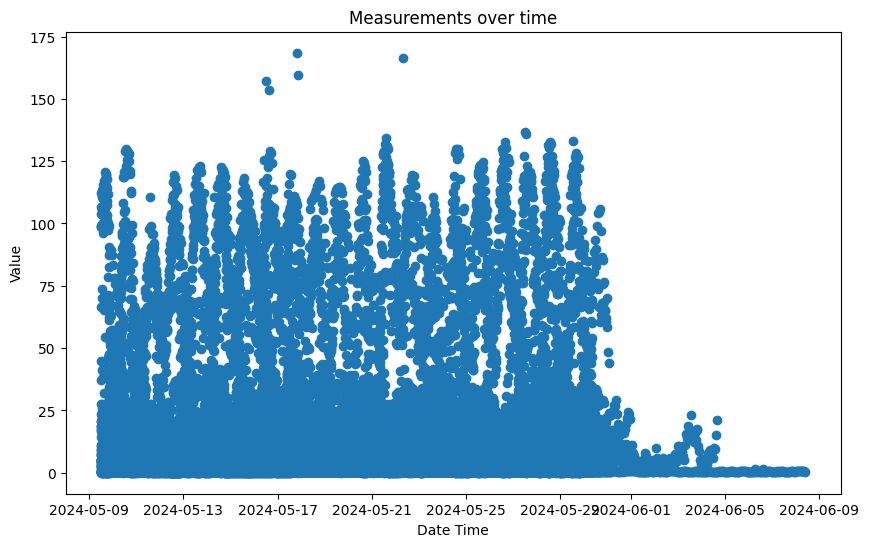

In [22]:
#### TEST ####
cur.execute("SELECT * FROM archive_measurements;")

rows = cur.fetchall()



df = pd.DataFrame(rows, columns=['sensor_id', 'sensor_code', 'date_time', 'value'])

print(df.head())

plt.figure(figsize=(10,6))
plt.scatter(df['date_time'], df['value'])
plt.xlabel('Date Time')
plt.ylabel('Value')
plt.title('Measurements over time')
plt.show()

## **Vizualization** 

**Map of Cities with Stations in Poland**

In [66]:
cities_df = pd.read_sql_query("SELECT * FROM cities;", conn)
stations_df = pd.read_sql_query("SELECT city_id, latitude, longitude, name FROM stations;", conn)

m = folium.Map(location=[52.2297, 21.0122], zoom_start=6)  # Poland
marker_cluster = MarkerCluster().add_to(m)

for idx, row in stations_df.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row['name'],
    ).add_to(marker_cluster)

warnings.filterwarnings("ignore")
m

**PM10 Pollution Levels In The 10 Largest Cities In Poland**

In [61]:
stations_df = pd.read_sql_query("SELECT station_id, city_id, name, latitude, longitude FROM stations;", conn)
cities_df = pd.read_sql_query("SELECT city_id, name FROM cities;", conn)

cities_of_interest = ["Warszawa", "Kraków", "Wrocław", "Łódź", "Poznań", 
                      "Gdańsk", "Szczecin", "Lublin", "Bydgoszcz", "Białystok"]

filtered_cities_df = cities_df[cities_df['name'].isin(cities_of_interest)]
filtered_stations_df = stations_df[stations_df['city_id'].isin(filtered_cities_df['city_id'])]

one_day_ago = (datetime.datetime.now() - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
measurements_query = f"""
    SELECT s.city_id, c.name AS city_name, am.date_time, am.value
    FROM actual_measurements am
    JOIN sensors se ON am.sensor_id = se.sensor_id
    JOIN stations s ON se.station_id = s.station_id
    JOIN cities c ON s.city_id = c.city_id
    JOIN params p ON se.param_id = p.param_id
    WHERE DATE(am.date_time) = DATE('{one_day_ago}')
      AND p.code = 'PM10'
      AND s.city_id IN ({','.join(map(str, filtered_cities_df['city_id'].tolist()))})
"""

measurements_df = pd.read_sql_query(measurements_query, conn)

cur.close()
conn.close()

measurements_df['date_time'] = pd.to_datetime(measurements_df['date_time'])
measurements_df['value'] = pd.to_numeric(measurements_df['value'], errors='coerce')
average_data = measurements_df.groupby(['city_name', pd.Grouper(key='date_time', freq='H')])['value'].mean().reset_index()

warnings.filterwarnings("ignore")

fig = px.line(average_data, x='date_time', y='value', color='city_name', title='Average PM10 Pollution Levels from the Previous Day')
fig.update_layout(xaxis_title='Time', yaxis_title='Average PM10 Pollution Level (µg/m³)', hovermode='closest')

fig.show()